In [1]:
!pip install datasets
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Load Dataset
file_path = 'manually_created_tos.csv'
data = pd.read_csv(file_path)

# Determine whether a GPU is available, and set it to gpu if available else set it to cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Data Preprocessing
data = data.dropna()  # Drop missing values
data['label'] = data['label'].map({'Risky': 0, 'Safe': 1, 'Information': 2})  # Encode label

# Split Dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42
)

In [4]:
# Tokenization
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
train_encodings = tokenize_function(train_texts.tolist())
val_encodings = tokenize_function(val_texts.tolist())

# Convert to Dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels.tolist()
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels.tolist()
})

dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset})

In [6]:
# Load Model
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3).to(device)

# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    load_best_model_at_end=True,
    weight_decay=0.01,
    logging_dir='./logs',
    save_total_limit=2,
    logging_steps=10,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    tokenizer=tokenizer,
)

# Fine-Tune Model
trainer.train()

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-6-7963f72b792e>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.099900,1.043973
2,0.786800,0.879946
3,0.579600,0.724756
4,0.309200,0.693929
5,0.253300,0.732325
6,0.144700,0.832138
7,0.136800,0.963329
8,0.014900,0.930066
9,0.007000,1.150196
10,0.013200,1.063353


TrainOutput(global_step=600, training_loss=0.36368236715594926, metrics={'train_runtime': 229.4704, 'train_samples_per_second': 41.53, 'train_steps_per_second': 2.615, 'total_flos': 56942855784960.0, 'train_loss': 0.36368236715594926, 'epoch': 10.0})

Accuracy:  0.7280334728033473
Precision:  [0.72222222 0.66197183 0.81666667]
Recall:  [0.84782609 0.78333333 0.56321839]
F1 Score:  [0.78       0.71755725 0.66666667]
Confusion Matrix:
[[78  5  9]
 [11 47  2]
 [19 19 49]]


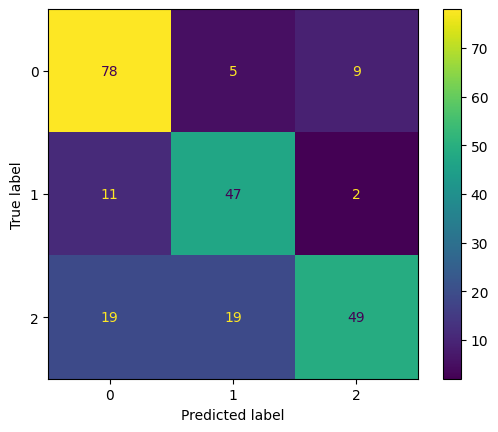

In [8]:
# Evaluation
predictions = trainer.predict(dataset['validation'])
pred_logits = torch.tensor(predictions.predictions).to(device)
pred_labels = torch.argmax(pred_logits, dim=1).tolist()
true_labels = dataset['validation']['labels']

# Calculate Metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

conf_matrix = confusion_matrix(true_labels, pred_labels)
print(f"Confusion Matrix:\n{conf_matrix}")
cm_display = ConfusionMatrixDisplay(conf_matrix)
cm_display.plot()
plt.show()